In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc

import seaborn as sns
import os

import scvi
import torch
import random

In [2]:
random.seed(123)

In [3]:
import math
import leidenalg

%matplotlib inline

In [4]:
if torch.cuda.is_available():
    print(f"CUDA is available. GPU: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available.")

CUDA is available. GPU: NVIDIA GeForce RTX 4060


In [5]:
n_epochs=125
top_n_genes=3000

analysis_name="Skin"
model_name="scanvimodel_{}epochs_top{}_{}".format(n_epochs,top_n_genes,analysis_name)

In [6]:
data_folder=os.path.join(".","data")
external_data_file=os.path.join(data_folder,"healthy.h5ad")
sc_data_file=os.path.join(data_folder,"SC_GEO_raw_counts.csv")

In [7]:
results_folder=os.path.join(data_folder,"ANALYSIS_SCVI_fin")
if not (os.path.exists(results_folder)):
    os.makedirs(results_folder)
    
model_folder=os.path.join(results_folder,model_name)

In [8]:
# Load the data
adata = sc.read_csv("data\SC_GEO_raw_counts.csv")
external_data_file="data/healthy.h5ad"
external_data_ori=sc.read_h5ad(external_data_file).raw.to_adata()

c:\Users\sangyeon\anaconda3\Lib\site-packages\anndata\_core\anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [9]:
external_data = external_data_ori.copy()
adata_prac = adata.copy()
adata_prac.var_names_make_unique()

# Assign gene names (ensure gene names are in the same order as in the raw counts file)
genes = pd.read_csv("data\SC_GEO_genes.csv")
adata_prac.var_names = genes['gene']

# Assign cell metadata (ensure cell barcodes are in the same order as the columns in the raw counts file)
cells = pd.read_csv("data\SC_GEO_cells.csv")
adata_prac.obs = cells.set_index('barcode')  # Make sure 'barcode' is the index

c:\Users\sangyeon\anaconda3\Lib\site-packages\anndata\_core\anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [10]:
if 'pass_QC' in cells.columns:
    adata_prac = adata_prac[adata_prac.obs['pass_QC'].astype(bool)].copy()

sc.pp.filter_genes(adata_prac, min_cells=int(0.1 * adata_prac.n_obs))

adata_prac.var['avgExpr']=np.transpose(
    np.divide(np.sum(adata_prac.X,axis=0),
              np.sum(adata_prac.X>0,axis=0)
             )
)

adata_prac.var['pass_QC']=(
    (
        (adata_prac.var['n_cells']>5) & 
        (~adata_prac.var['avgExpr'].isna()) & 
        (adata_prac.var['avgExpr']>1.5)
    )
)
adata_prac=adata_prac[: ,adata_prac.var['pass_QC']]

adata_prac.raw = adata_prac

c:\Users\sangyeon\anaconda3\Lib\site-packages\anndata\_core\anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [11]:
# Step 2: Identify Top 3000 Most Variable Genes
# Use the Seurat method for variable genes selection
adata_prac.layers['counts'] = adata_prac.X.copy()
sc.pp.normalize_total(adata_prac, target_sum=10e4)
sc.pp.log1p(adata_prac)
sc.pp.highly_variable_genes(adata_prac, flavor='seurat_v3', layer='counts', n_top_genes=3000, subset=False, batch_key='batch')


In [12]:
external_data

AnnData object with n_obs × n_vars = 195739 × 28728
    obs: 'sample_id', 'Status', 'Site', 'Tissue', 'Location', 'donor_id', 'Sex', 'full_clustering'
    var: 'gene_ids-SKN8090524', 'feature_types-SKN8090524', 'gene_ids-SKN8090525', 'feature_types-SKN8090525', 'gene_ids-SKN8090526', 'feature_types-SKN8090526', 'gene_ids-SKN8090527', 'feature_types-SKN8090527', 'gene_ids-SKN8090528', 'feature_types-SKN8090528', 'gene_ids-SKN8090529', 'feature_types-SKN8090529', 'gene_ids-SKN8090530', 'feature_types-SKN8090530', 'gene_ids-SKN8090531', 'feature_types-SKN8090531', 'gene_ids-SKN8090536', 'feature_types-SKN8090536', 'gene_ids-SKN8090537', 'feature_types-SKN8090537', 'gene_ids-SKN8090538', 'feature_types-SKN8090538', 'gene_ids-SKN8090539', 'feature_types-SKN8090539', 'gene_ids-SKN8090540', 'feature_types-SKN8090540', 'gene_ids-SKN8090541', 'feature_types-SKN8090541', 'gene_ids-SKN8090542', 'feature_types-SKN8090542', 'gene_ids-SKN8090543', 'feature_types-SKN8090543', 'gene_ids-SKN8090548', '

In [13]:

external_data.obs.columns=['sample','Status','Site','tissue','location','patient','sex','cell_type']
external_data.obs=external_data.obs.drop(['Status','Site','location','sex'],axis=1)
external_data.obs['hto_demux']=None
external_data.obs['batch']=external_data.obs['sample']
external_data.obs['pass_QC']=True
external_data.obs['visit']=None
external_data.obs['nGenes']=np.sum(external_data.X > 0,axis=1)
external_data.obs['nUMIs']=np.sum(external_data.X,axis=1)

In [14]:
external_data.var.head()

gene_ids-SKN8090524  feature_types-SKN8090524 gene_ids-SKN8090525  \
index                                                                           
MIR1302-2HG     ENSG00000243485                         0     ENSG00000243485   
AL627309.1      ENSG00000238009                         0     ENSG00000238009   
AL627309.3      ENSG00000239945                         0     ENSG00000239945   
AL627309.2      ENSG00000239906                         0     ENSG00000239906   
AL732372.1      ENSG00000236601                         0     ENSG00000236601   

             feature_types-SKN8090525 gene_ids-SKN8090526  \
index                                                       
MIR1302-2HG                         0     ENSG00000243485   
AL627309.1                          0     ENSG00000238009   
AL627309.3                          0     ENSG00000239945   
AL627309.2                          0     ENSG00000239906   
AL732372.1                          0     ENSG00000236601   

             feature_types-SKN8090526 gene_ids-SKN8090527  \
index                                                       
MIR1302-2HG                         0     ENSG00000243485   
AL627309.1                          0     ENSG00000238009   
AL627309.3                          0     ENSG00000239945   
AL627309.2                          0     ENSG00000239906   
AL732372.1                          0     ENSG00000236601   

             feature_types-SKN8090527 gene_ids-SKN8090528  \
index                                                       
MIR1302-2HG                         0     ENSG00000243485   
AL627309.1                          0     ENSG00000238009   
AL627309.3                          0     ENSG00000239945   
AL627309.2                          0     ENSG00000239906   
AL732372.1                          0     ENSG00000236601   

             feature_types-SKN8090528  ... feature_types-4820STDY7389010  \
index                                  ...                                 
MIR1302-2HG                         0  ...                             0   
AL627309.1                          0  ...                             0   
AL627309.3                          0  ...                             0   
AL627309.2                          0  ...                             0   
AL732372.1                          0  ...                             0   

             gene_ids-4820STDY7389011 feature_types-4820STDY7389011  \
index                                                                 
MIR1302-2HG           ENSG00000243485                             0   
AL627309.1            ENSG00000238009                             0   
AL627309.3            ENSG00000239945                             0   
AL627309.2            ENSG00000239906                             0   
AL732372.1            ENSG00000236601                             0   

             gene_ids-4820STDY7389012 feature_types-4820STDY7389012  \
index                                                                 
MIR1302-2HG           ENSG00000243485                             0   
AL627309.1            ENSG00000238009                             0   
AL627309.3            ENSG00000239945                             0   
AL627309.2            ENSG00000239906                             0   
AL732372.1            ENSG00000236601                             0   

             gene_ids-4820STDY7389013 feature_types-4820STDY7389013  \
index                                                                 
MIR1302-2HG           ENSG00000243485                             0   
AL627309.1            ENSG00000238009                             0   
AL627309.3            ENSG00000239945                             0   
AL627309.2            ENSG00000239906                             0   
AL732372.1            ENSG00000236601                             0   

             gene_ids-4820STDY7389014 feature_types-4820STDY7389014  n_cells  
index                                                 

In [15]:
external_data.var=pd.DataFrame(
    {'gene_ids':external_data.var['gene_ids-SKN8090524'],
     'nCells':external_data.var['n_cells']},
    index=external_data.var.index
)

external_data.var['avgExpr']=np.transpose(
    np.divide(np.sum(external_data.X,axis=0),
              np.sum(external_data.X>0,axis=0)
             )
)
external_data.var['pass_QC']=(
    (external_data.var['nCells']>0.1*external_data.shape[0]) | 
    (
        (external_data.var['nCells']>5) & 
        (~external_data.var['avgExpr'].isna()) & 
        (external_data.var['avgExpr']>1.5)
    )
)
external_data=external_data[: ,external_data.var['pass_QC']]

C:\Users\sangyeon\AppData\Local\Temp\ipykernel_4664\1510494220.py:8: RuntimeWarning: invalid value encountered in divide
  np.divide(np.sum(external_data.X,axis=0),


In [16]:
external_data.raw = external_data

In [17]:
external_data.var

gene_ids  nCells    avgExpr  pass_QC
index                                                 
LINC00115  ENSG00000225880   25909   1.066493     True
NOC2L      ENSG00000188976   73177   1.232349     True
HES4       ENSG00000188290   45674   1.410696     True
ISG15      ENSG00000187608   98887   3.240481     True
AGRN       ENSG00000188157   34982   1.440326     True
...                    ...     ...        ...      ...
MT-ND4L    ENSG00000212907  431192  22.390017     True
MT-ND4     ENSG00000198886  466390  20.828992     True
MT-ND5     ENSG00000198786  431867  10.594023     True
MT-ND6     ENSG00000198695  153150   2.988433     True
MT-CYB     ENSG00000198727  478152  31.528396     True

[9665 rows x 4 columns]

In [18]:
external_data.layers['counts'] = external_data.X.copy()
sc.pp.normalize_total(external_data, target_sum=10e4)
sc.pp.log1p(external_data)
sc.pp.highly_variable_genes(external_data, flavor='seurat_v3', layer='counts', n_top_genes=top_n_genes, subset=False, batch_key='batch')

In [19]:
adata_prac.obs['cell_type']='Unknown'

In [20]:
all_data = adata_prac.concatenate(external_data)

C:\Users\sangyeon\AppData\Local\Temp\ipykernel_4664\1989820275.py:1: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  all_data = adata_prac.concatenate(external_data)


In [21]:
all_data=all_data[:,all_data.var['highly_variable-0'] | all_data.var['highly_variable-1']].copy()
#all_data.write(os.path.join(results_folder,"scanvi.h5ad"))
del(adata_prac,external_data)

In [22]:
all_data.obs['cell_type'].value_counts()

cell_type
Unknown                56114
Differentiated_KC      32496
Undifferentiated_KC    21348
Th                     20617
VE2                    15511
moDC                   12490
migLC                  11977
F1                     10161
VE1                     9645
Tc                      8680
Macro_1                 5781
Treg                    5743
Mono_mac                4912
Pericyte_1              4705
F2                      4260
LE2                     3851
Melanocyte              3682
F3                      3035
ILC1_3                  2935
ILC1_NK                 2604
MigDC                   2080
Inf_mac                 1773
Macro_2                 1424
LE1                     1073
NK                       739
DC2                      724
VE3                      629
DC1                      604
LC                       568
Mast_cell                557
ILC2                     494
Pericyte_2               301
Schwann_1                149
Schwann_2                120
Plas

In [23]:
if os.path.exists(model_folder):
    lvae = scvi.model.SCANVI.load(model_folder,adata=all_data)
else:
    scvi.model.SCVI.setup_anndata(
        all_data,
        layer="counts",
        batch_key="batch",
        labels_key="cell_type"
    )
    lvae = scvi.model.SCVI(all_data, n_layers=2, n_latent=30)
    lvae.train(max_epochs=125)

    scvi.model.SCANVI.setup_anndata(
        lvae,
        unlabeled_category="Unknown",
        labels_key="cell_type"
    )
    lvae.train(max_epochs=25)
    lvae.save(model_folder, overwrite=True, save_anndata=False)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\sangyeon\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Epoch 13/125:  10%|▉         | 12/125 [02:04<19:23, 10.30s/it, v_num=1, train_loss_step=2.32e+3, train_loss_epoch=2.33e+3]

RuntimeError: [enforce fail at alloc_cpu.cpp:114] data. DefaultCPUAllocator: not enough memory: you tried to allocate 1506304 bytes.

In [ ]:
history=lvae.history['elbo_train'].reset_index()

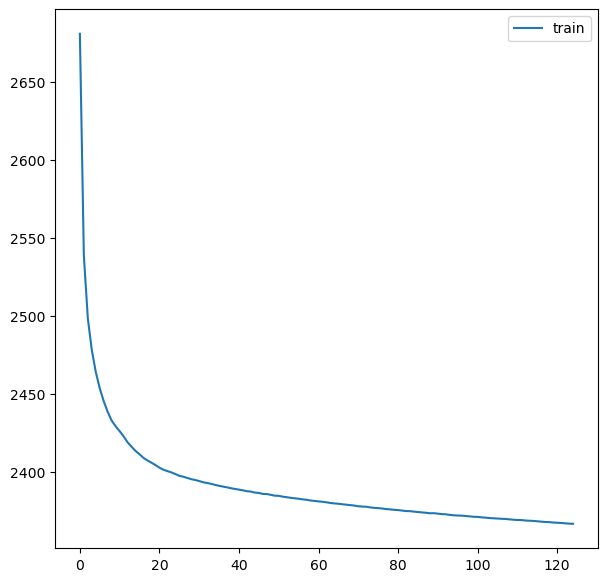

In [ ]:
fig, ax = plt.subplots(figsize=(7,7))

ax.plot(history['epoch'], history['elbo_train'], label='train')
_=ax.legend()

In [ ]:
all_data.obsm["X_scVI"] = lvae.get_latent_representation()

In [ ]:
lvae

ScanVI Model with the following params: 
unlabeled_category: Unknown, n_hidden: 128, n_latent: 30, n_layers: 2, dropout_rate: 0.1, dispersion: gene, 
gene_likelihood: zinb
Training status: Trained
Model's adata is minified?: False

In [ ]:
all_data.obs["C_scANVI"] = lvae.predict(all_data, soft=False)

In [ ]:

all_data.obs._scvi_batch.value_counts()

_scvi_batch
1    195739
0     56114
Name: count, dtype: int64

In [ ]:
all_data.obs

num_genes     umis   mt_perc  ribo_perc  \
AAACCCATCCATCGTC-1-0                     1862.0   5165.0  6.602130  14.424008   
AAACGAAAGTTGTCAC-1-0                     3966.0  14825.0  5.268128  13.753794   
AAACGCTCAATTGTGC-1-0                     3056.0  13065.0  4.064294  24.975124   
AAACGCTTCGTCTCAC-1-0                     1615.0   5856.0  4.952186  29.525274   
AAAGAACAGGGCAACT-1-0                     3386.0  12693.0  3.324667  30.757110   
...                                         ...      ...       ...        ...   
TTTGGTTTCAGGCCCA-1-4820STDY7389014-1        NaN      NaN       NaN        NaN   
TTTGGTTTCGCCTGTT-1-4820STDY7389014-1        NaN      NaN       NaN        NaN   
TTTGTCAAGGAATCGC-1-4820STDY7389014-1        NaN      NaN       NaN        NaN   
TTTGTCAAGGACTGGT-1-4820STDY7389014-1        NaN      NaN       NaN        NaN   
TTTGTCACACTACAGT-1-4820STDY7389014-1        NaN      NaN       NaN        NaN   

                                     batch patient visit             tissue  \
AAACCCATCCATCGTC-1-0                     0     P01   V00  Non-lesional skin   
AAACGAAAGTTGTCAC-1-0                     0     P01   V00      Lesional skin   
AAACGCTCAATTGTGC-1-0                     0     P01   V00      Lesional skin   
AAACGCTTCGTCTCAC-1-0                     0     P01   V00      Lesional skin   
AAAGAACAGGGCAACT-1-0                     0     P01   V00      Lesional skin   
...                                    ...     ...   ...                ...   
TTTGGTTTCAGGCCCA-1-4820STDY7389014-1     1      S3   NaN          Epidermis   
TTTGGTTTCGCCTGTT-1-4820STDY7389014-1     1      S3   NaN          Epidermis   
TTTGTCAAGGAATCGC-1-4820STDY7389014-1     1      S3   NaN          Epidermis   
TTTGTCAAGGACTGGT-1-4820STDY7389014-1     1      S3   NaN          Epidermis   
TTTGTCACACTACAGT-1-4820STDY7389014-1     1      S3   NaN          Epidermis   

                                     cell_type  pass_QC           sample  \
AAACCCATCCATCGTC-1-0                   Unknown     True              NaN   
AAACGAAAGTTGTCAC-1-0                   Unknown     True              NaN   
AAACGCTCAATTGTGC-1-0                   Unknown     True              NaN   
AAACGCTTCGTCTCAC-1-0                   Unknown     True              NaN   
AAAGAACAGGGCAACT-1-0                   Unknown     True              NaN   
...                                        ...      ...              ...   
TTTGGTTTCAGGCCCA-1-4820STDY7389014-1     migLC     True  4820STDY7389014   
TTTGGTTTCGCCTGTT-1-4820STDY7389014-1        Th     True  4820STDY7389014   
TTTGTCAAGGAATCGC-1-4820STDY7389014-1        Th     True  4820STDY7389014   
TTTGTCAAGGACTGGT-1-4820STDY7389014-1        Th     True  4820STDY7389014   
TTTGTCACACTACAGT-1-4820STDY7389014-1        Th     True  4820STDY7389014   

                                     hto_demux  nGenes   nUMIs  _scvi_batch  \
AAACCCATCCATCGTC-1-0                       NaN     NaN     NaN            0   
AAACGAAAGTTGTCAC-1-0                       NaN     NaN     NaN            0   
AAACGCTCAATTGTGC-1-0                       NaN     NaN     NaN            0   
AAACGCTTCGTCTCAC-1-0                       NaN     NaN     NaN            0   
AAAGAACAGGGCAACT-1-0                       NaN     NaN     NaN            0   
...                                        ...     ...     ...          ...   
TTTGGTTTCAGGCCCA-1-4820STDY7389014-1      None   455.0  1023.0            1   
TTTGGTTTCGCCTGTT-1-4820STDY7389014-1      None  1228.0  4430.0            1   
TTTGTCAAGGAATCGC-1-4820STDY7389014-1      None   739.0  2633.0            1   
TTTGTCAAGGACTGGT-1-4820STDY7389014-1      None  1390.0  3394.0            1   
TTTGTCACACTACAGT-1-4820STDY7389014-1      None  1051.0  3469.0            1   

                                      _scvi_labels   C_scANVI  
AAACCCATCCATCGTC-1-0                            34         Tc  
AAACGAAAGTTGTCAC-1-0                            34  Schwann_1  
AAACGCTCAATTGTGC-1-0                            34        VE2 

In [ ]:
all_data.obs[all_data.obs.batch=='0'].C_scANVI.value_counts()

C_scANVI
Th                     14401
Macro_1                 7601
Tc                      5527
F2                      4773
VE2                     3302
Treg                    2815
Mono_mac                2645
Macro_2                 2561
F3                      1596
DC1                     1107
Mast_cell                976
ILC1_NK                  910
Pericyte_1               804
Inf_mac                  777
migLC                    773
DC2                      657
F1                       607
Differentiated_KC        583
VE1                      546
moDC                     535
LE1                      507
VE3                      499
Melanocyte               413
Undifferentiated_KC      270
Pericyte_2               213
MigDC                    207
ILC1_3                   155
NK                       153
LE2                      122
Schwann_2                 34
Plasma                    16
ILC2                      13
Schwann_1                 11
LC                         5
Name:

In [ ]:
sc.pp.neighbors(all_data, use_rep="X_scVI")
sc.tl.umap(all_data)

In [ ]:
sc.set_figure_params(figsize=(10,10))

c:\Users\sangyeon\anaconda3\Lib\site-packages\anndata\_core\anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
c:\Users\sangyeon\anaconda3\Lib\site-packages\anndata\_core\anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
c:\Users\sangyeon\anaconda3\Lib\site-packages\anndata\_core\anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
c:\Users\sangyeon\anaconda3\Lib\site-packages\anndata\_core\anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


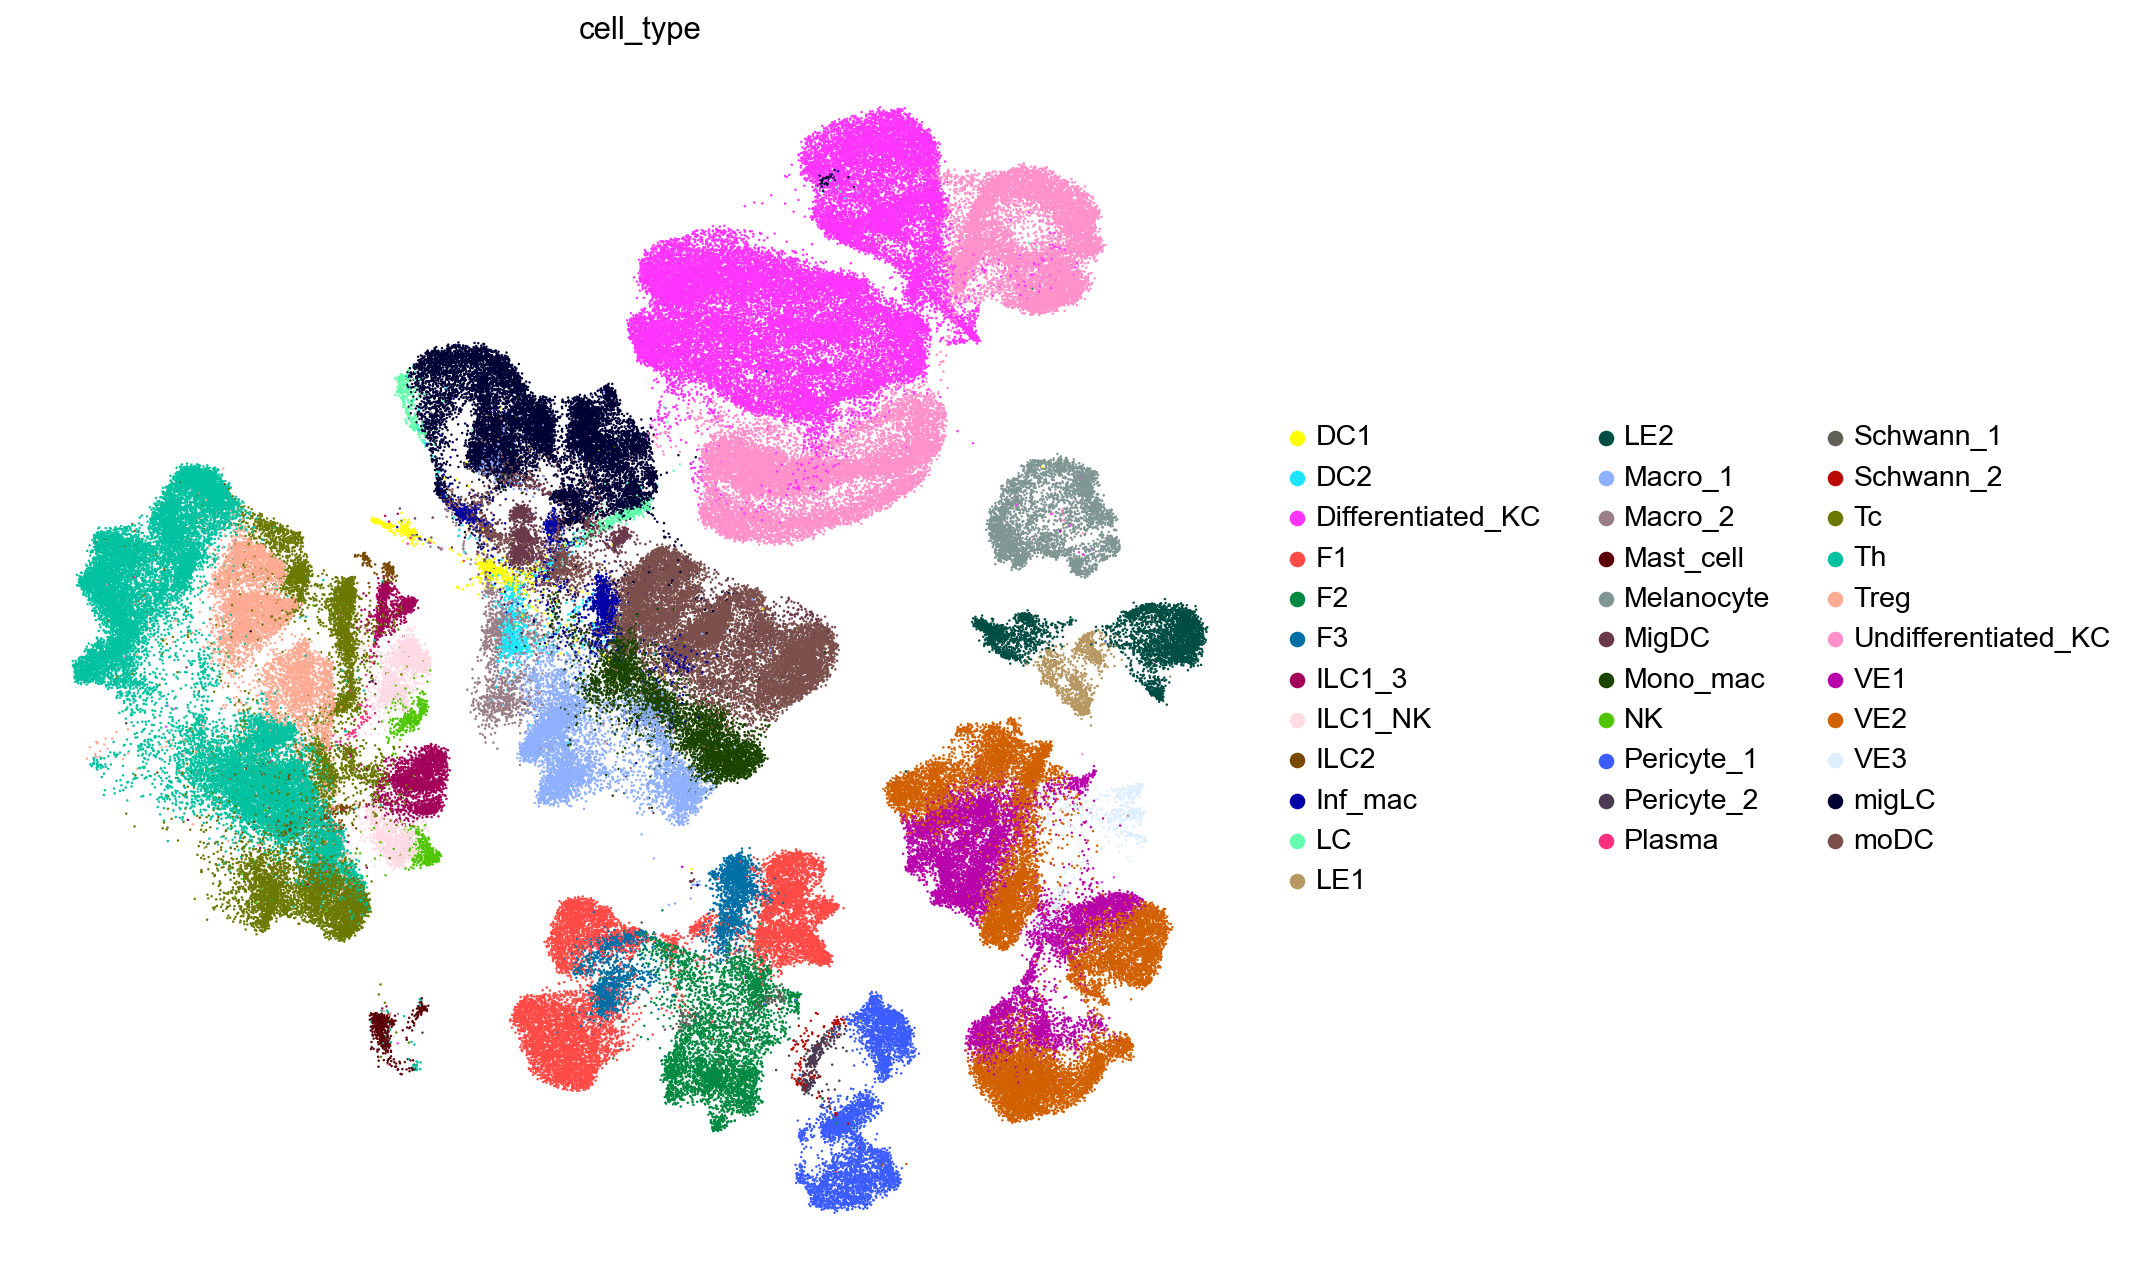

In [ ]:
sc.pl.umap(all_data[all_data.obs['batch']=='1'], color=["cell_type"], ncols=1, frameon=False,size=5)

c:\Users\sangyeon\anaconda3\Lib\site-packages\anndata\_core\anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
c:\Users\sangyeon\anaconda3\Lib\site-packages\anndata\_core\anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
c:\Users\sangyeon\anaconda3\Lib\site-packages\anndata\_core\anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
c:\Users\sangyeon\anaconda3\Lib\site-packages\anndata\_core\anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
c:\Users\sangyeon\anaconda3\Lib\site-packages\anndata\_core\anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


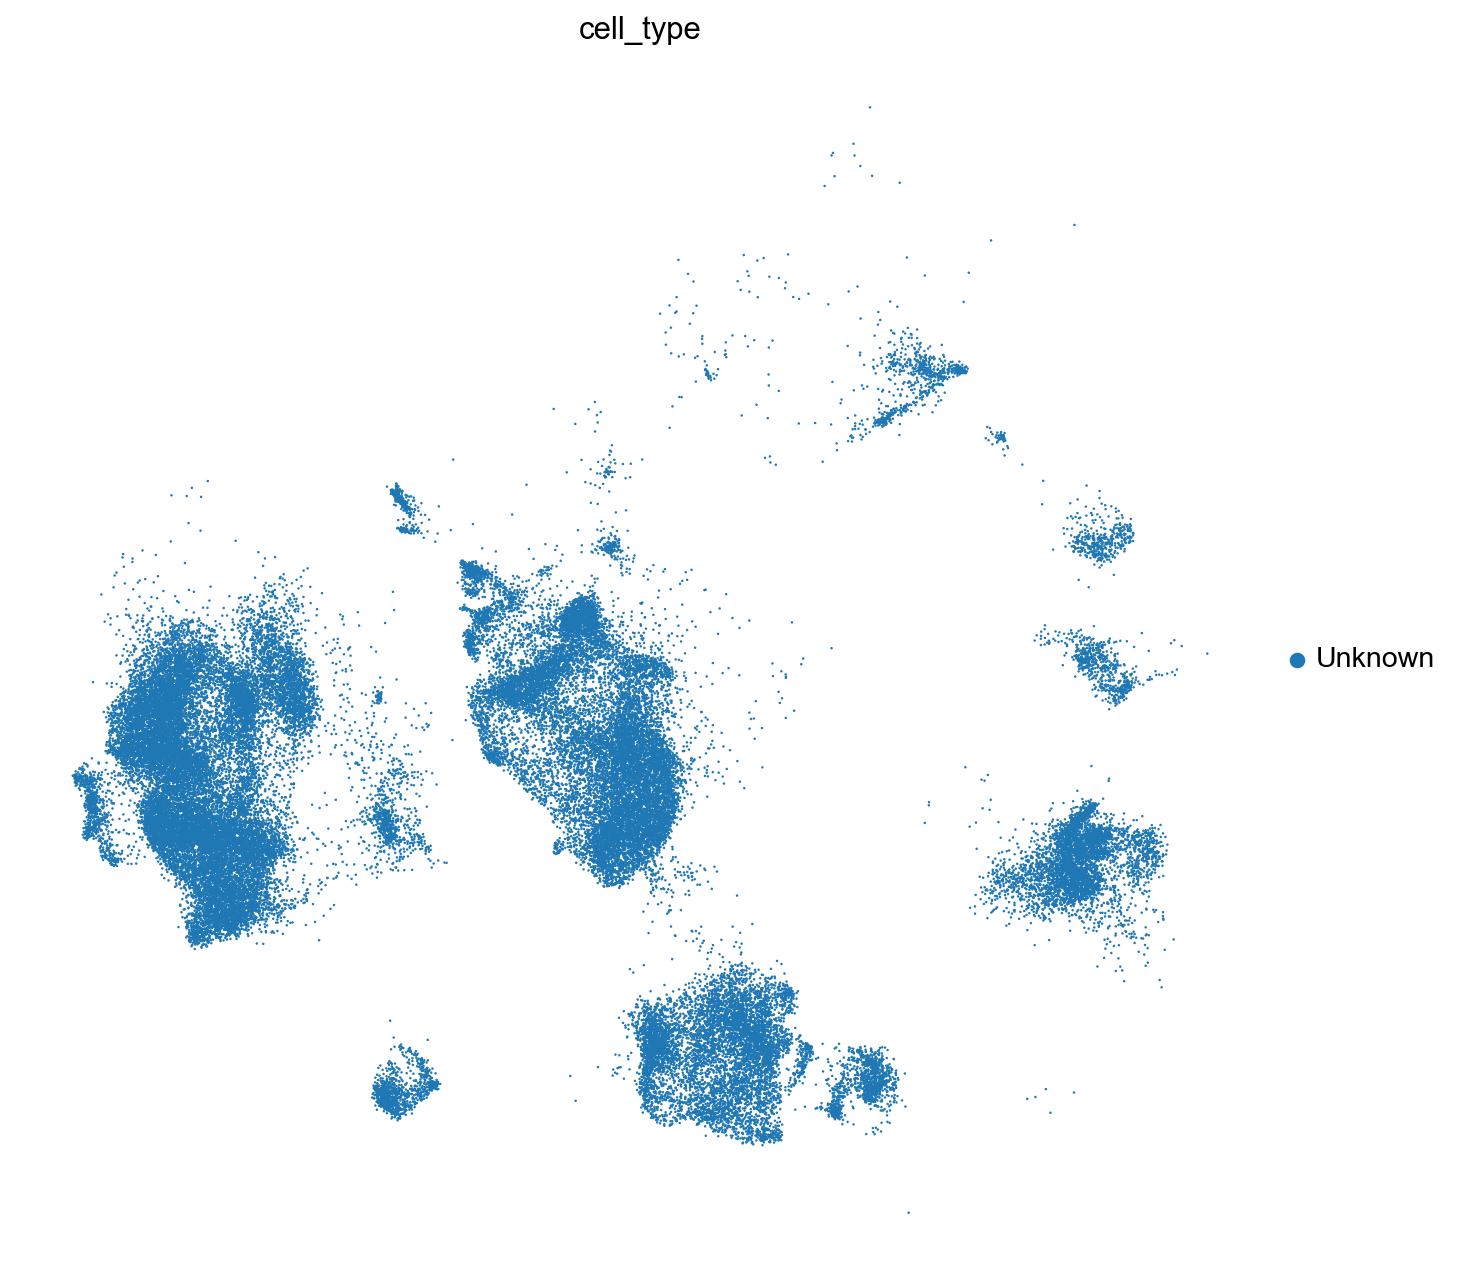

In [ ]:
sc.pl.umap(all_data[all_data.obs['batch']=='0'], color=["cell_type"], ncols=1, frameon=False,size=5)

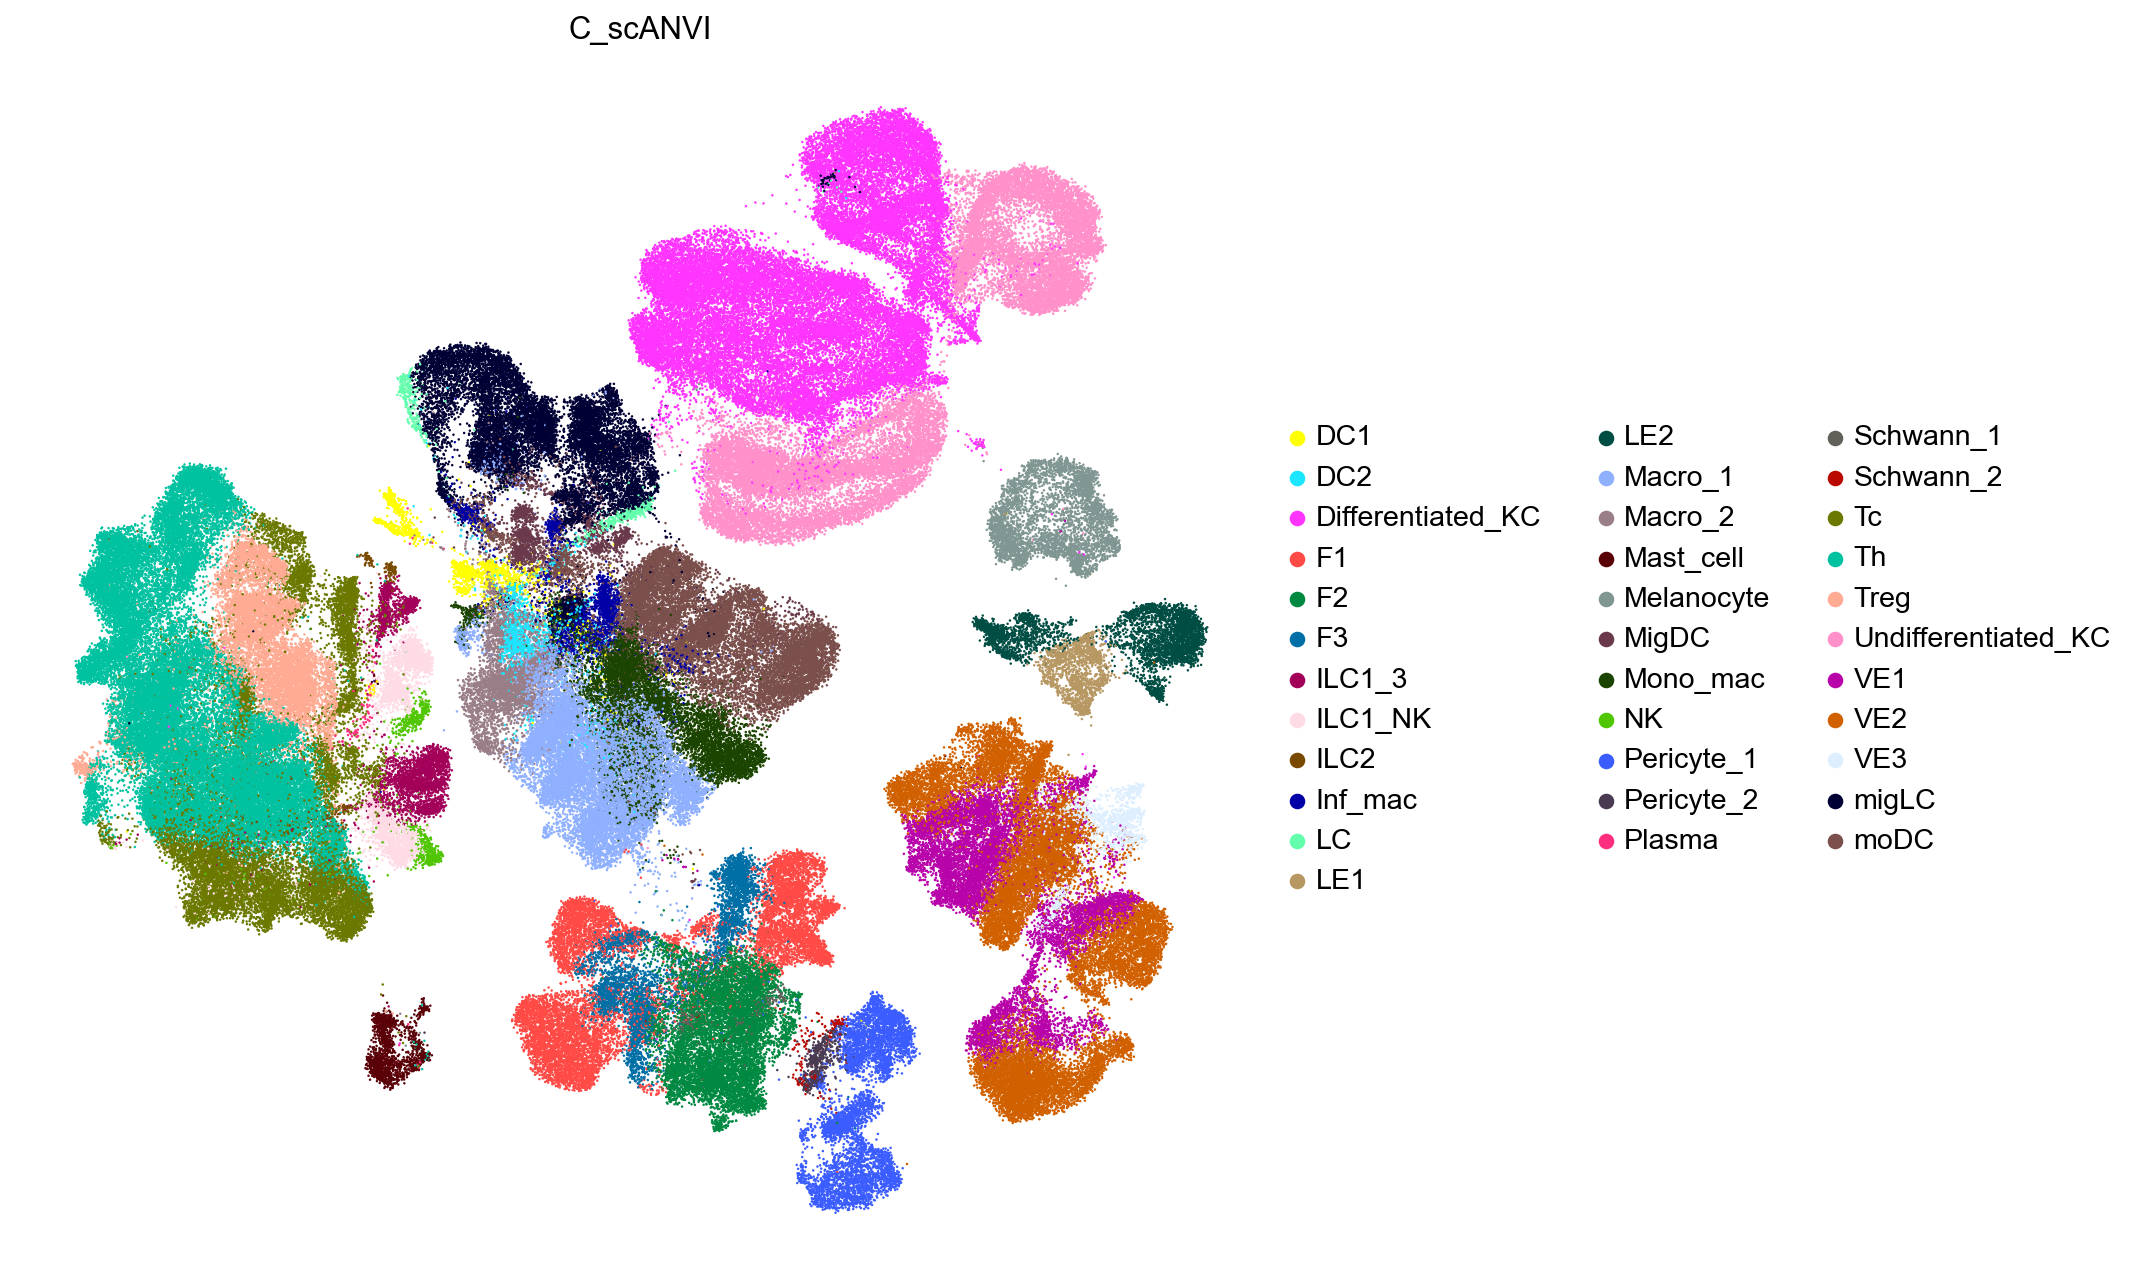

In [ ]:
sc.pl.umap(all_data, color=["C_scANVI"], ncols=1, frameon=False,size=5)

In [ ]:
cell_types=all_data.obs[all_data.obs['batch']=='0'][['C_scANVI']]

In [ ]:
cell_types.C_scANVI.value_counts()

C_scANVI
Th                     14401
Macro_1                 7601
Tc                      5527
F2                      4773
VE2                     3302
Treg                    2815
Mono_mac                2645
Macro_2                 2561
F3                      1596
DC1                     1107
Mast_cell                976
ILC1_NK                  910
Pericyte_1               804
Inf_mac                  777
migLC                    773
DC2                      657
F1                       607
Differentiated_KC        583
VE1                      546
moDC                     535
LE1                      507
VE3                      499
Melanocyte               413
Undifferentiated_KC      270
Pericyte_2               213
MigDC                    207
ILC1_3                   155
NK                       153
LE2                      122
Schwann_2                 34
Plasma                    16
ILC2                      13
Schwann_1                 11
LC                         5
Name:

In [ ]:
cell_types.index=cell_types.index.str.extract("([A-Z]+-[0-9]+)-0")[0]

In [ ]:
cell_types.head()

C_scANVI
0                            
AAACCCATCCATCGTC-1         Tc
AAACGAAAGTTGTCAC-1  Schwann_1
AAACGCTCAATTGTGC-1        VE2
AAACGCTTCGTCTCAC-1         Th
AAAGAACAGGGCAACT-1         F2

In [ ]:
analysis_name="skin_tcells"

t_cells=all_data[all_data.obs['C_scANVI']=='Th',:].raw.to_adata()


In [ ]:
t_cells=t_cells[t_cells.obs['cell_type'].isin(['Unknown','Th','Tc','Treg','ILC1_3','ILC1_NK','NK','ILC2','Plasma'])].copy()

In [ ]:
t_cells.obs.cell_type.value_counts()

cell_type
Th         20070
Unknown    14401
Tc           144
Treg         141
ILC2         100
Plasma         3
NK             2
ILC1_3         1
Name: count, dtype: int64

In [ ]:
top_n_genes=2000
n_epochs=100
model_name="scanvimodel_{}epochs_top{}_{}".format(n_epochs,top_n_genes,analysis_name)

model_folder=os.path.join(results_folder,model_name)

In [ ]:
t_cells.raw = t_cells 

t_cells.layers['counts'] = t_cells.X.copy()

sc.pp.normalize_total(t_cells, target_sum=10e4)
sc.pp.log1p(t_cells)
sc.pp.highly_variable_genes(t_cells, flavor='seurat_v3', layer='counts', n_top_genes=top_n_genes, subset=False, batch_key='batch')
t_cells=t_cells[:,t_cells.var['highly_variable']].copy()

c:\Users\sangyeon\anaconda3\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:72: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


In [ ]:
scvi.model.SCANVI.setup_anndata(
    t_cells,
    layer="counts",
    batch_key="batch",
    labels_key="cell_type",
    unlabeled_category="Unknown",
)

c:\Users\sangyeon\anaconda3\Lib\site-packages\scvi\data\fields\_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
c:\Users\sangyeon\anaconda3\Lib\site-packages\scvi\data\fields\_dataframe_field.py:183: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  categorical_mapping = _make_column_categorical(
c:\Users\sangyeon\anaconda3\Lib\site-packages\scvi\data\fields\_scanvi.py:56: UserWarning: Category 0 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(


In [ ]:
if os.path.exists(model_folder):
    lvae = scvi.model.SCANVI.load(model_folder,adata=t_cells)
else:
    lvae = scvi.model.SCANVI(t_cells, n_layers=2, n_latent=30)
    lvae.train(max_epochs=n_epochs)
    lvae.save(model_folder, overwrite=True, save_anndata=False)

INFO     Training for 100 epochs.                                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\sangyeon\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Epoch 1/100:   0%|          | 0/100 [00:00<?, ?it/s]

c:\Users\sangyeon\anaconda3\Lib\site-packages\scvi\module\_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
c:\Users\sangyeon\anaconda3\Lib\site-packages\scvi\module\_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 2/100:   1%|          | 1/100 [00:03<05:49,  3.53s/it, v_num=1, train_loss_step=1.91e+3, train_loss_epoch=1.93e+3]

c:\Users\sangyeon\anaconda3\Lib\site-packages\scvi\module\_scanvae.py:304: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 100/100: 100%|██████████| 100/100 [05:23<00:00,  3.13s/it, v_num=1, train_loss_step=1.59e+3, train_loss_epoch=1.64e+3]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [05:23<00:00,  3.23s/it, v_num=1, train_loss_step=1.59e+3, train_loss_epoch=1.64e+3]


In [ ]:
history=lvae.history['elbo_train'].reset_index()

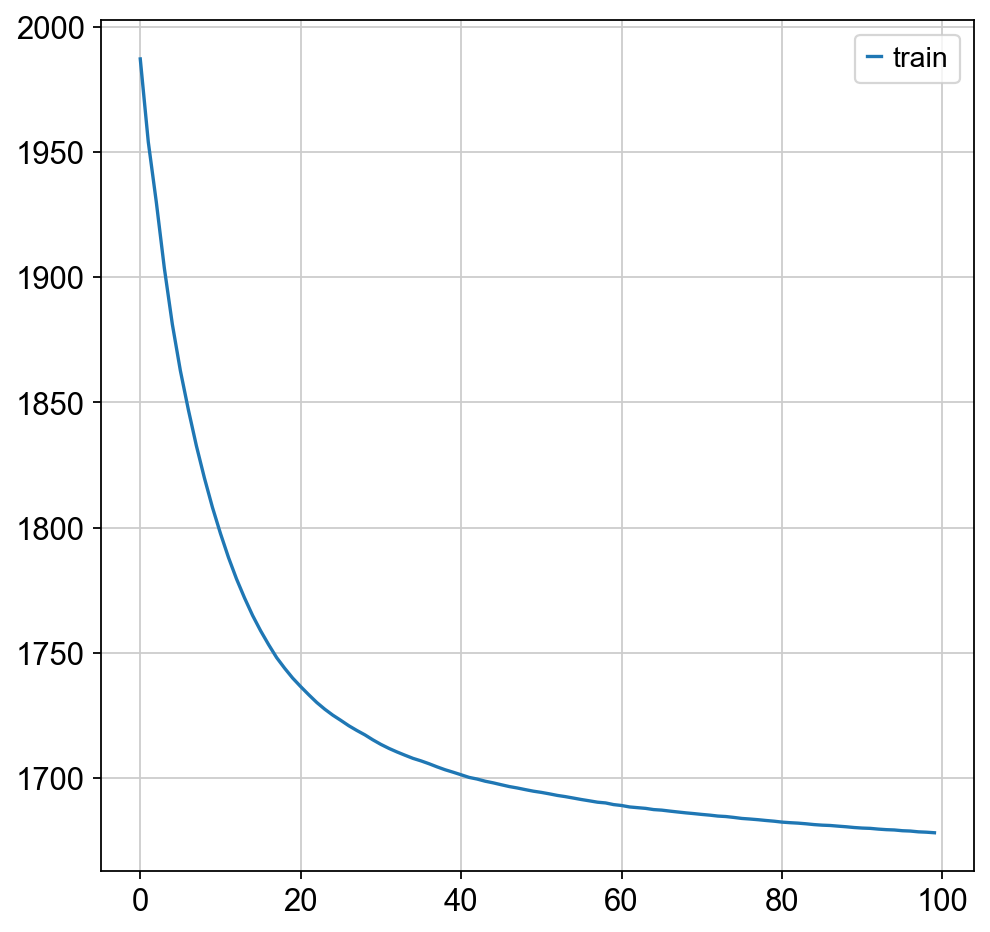

In [ ]:
fig, ax = plt.subplots(figsize=(7,7))

ax.plot(history['epoch'], history['elbo_train'], label='train')
_=ax.legend()

In [ ]:
t_cells.obsm["X_scVI"] = lvae.get_latent_representation()

In [ ]:
t_cells.obs["C_scANVI"] = lvae.predict(t_cells, soft=False)

In [ ]:
sc.pp.neighbors(t_cells, use_rep="X_scVI")
sc.tl.umap(t_cells)

Epoch 1/100:   0%|          | 0/100 [06:37<?, ?it/s]


In [ ]:
sc.set_figure_params(figsize=(10,10))

c:\Users\sangyeon\anaconda3\Lib\site-packages\anndata\_core\anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


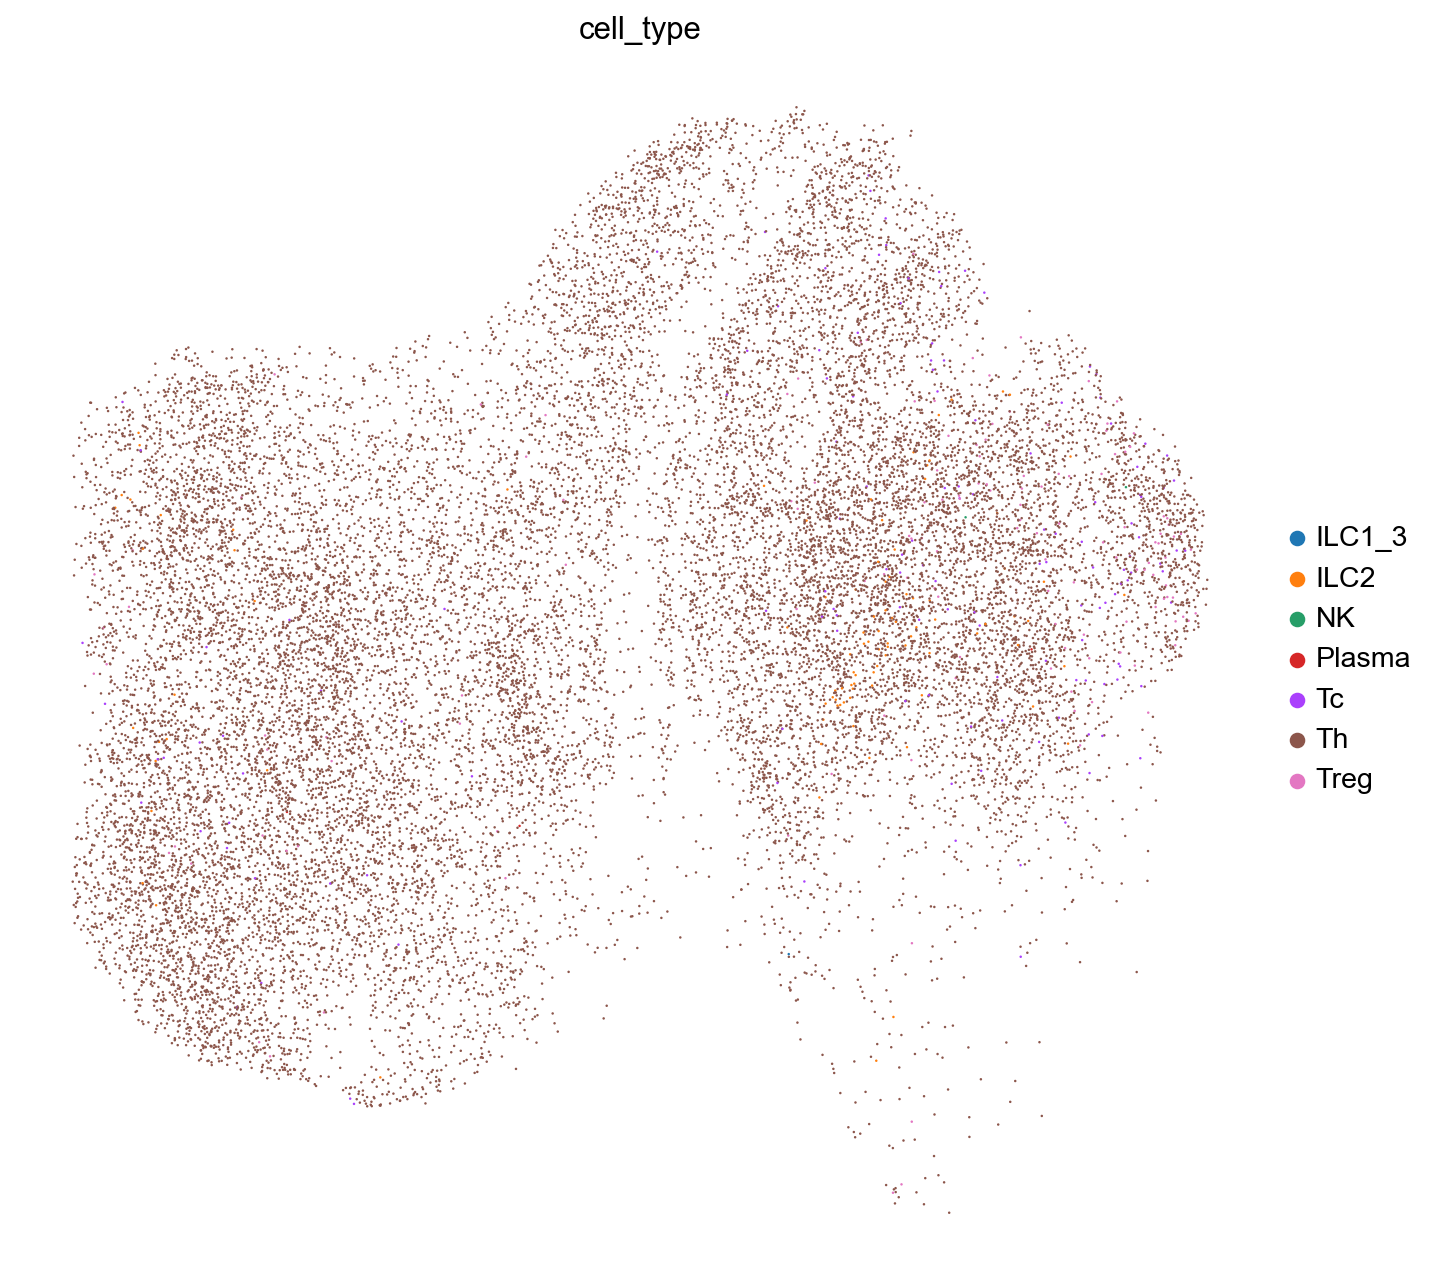

In [ ]:
sc.pl.umap(t_cells[t_cells.obs['batch']=='1'], color=["cell_type"], ncols=1, frameon=False,size=5)

c:\Users\sangyeon\anaconda3\Lib\site-packages\anndata\_core\anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


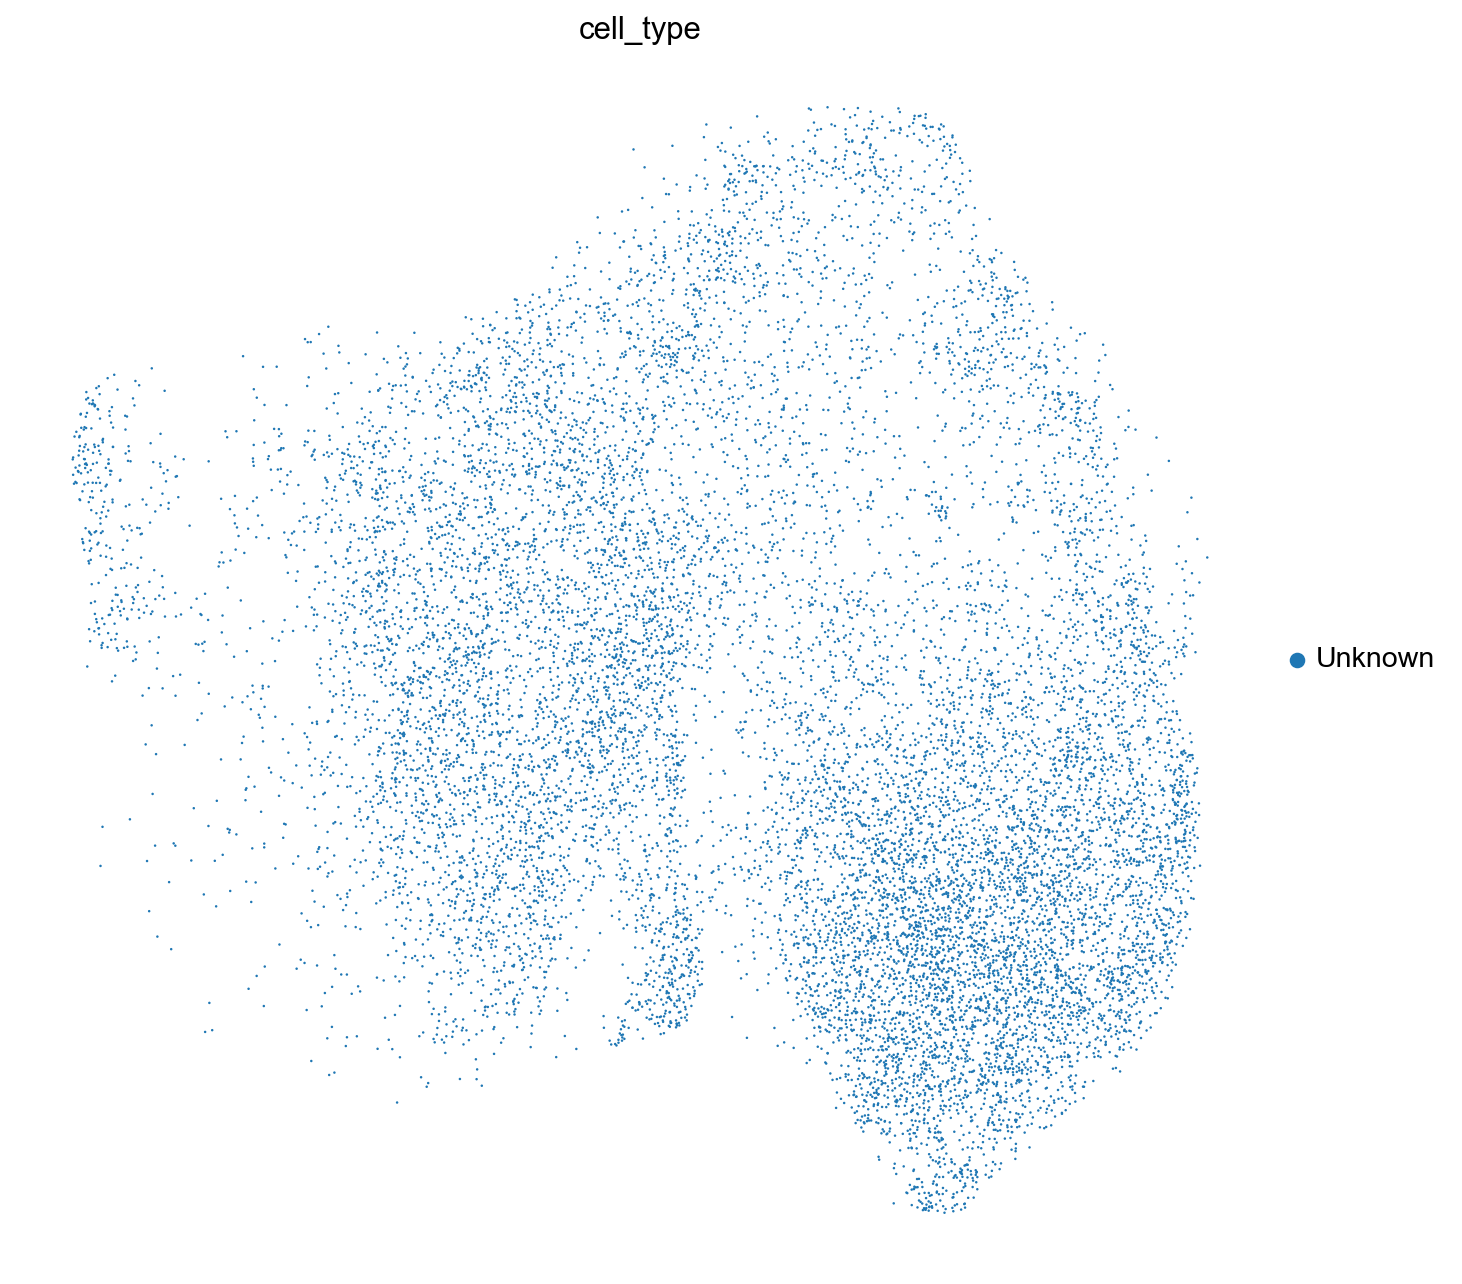

In [ ]:
sc.pl.umap(t_cells[t_cells.obs['batch']=='0'], color=["cell_type"], ncols=1, frameon=False,size=5)

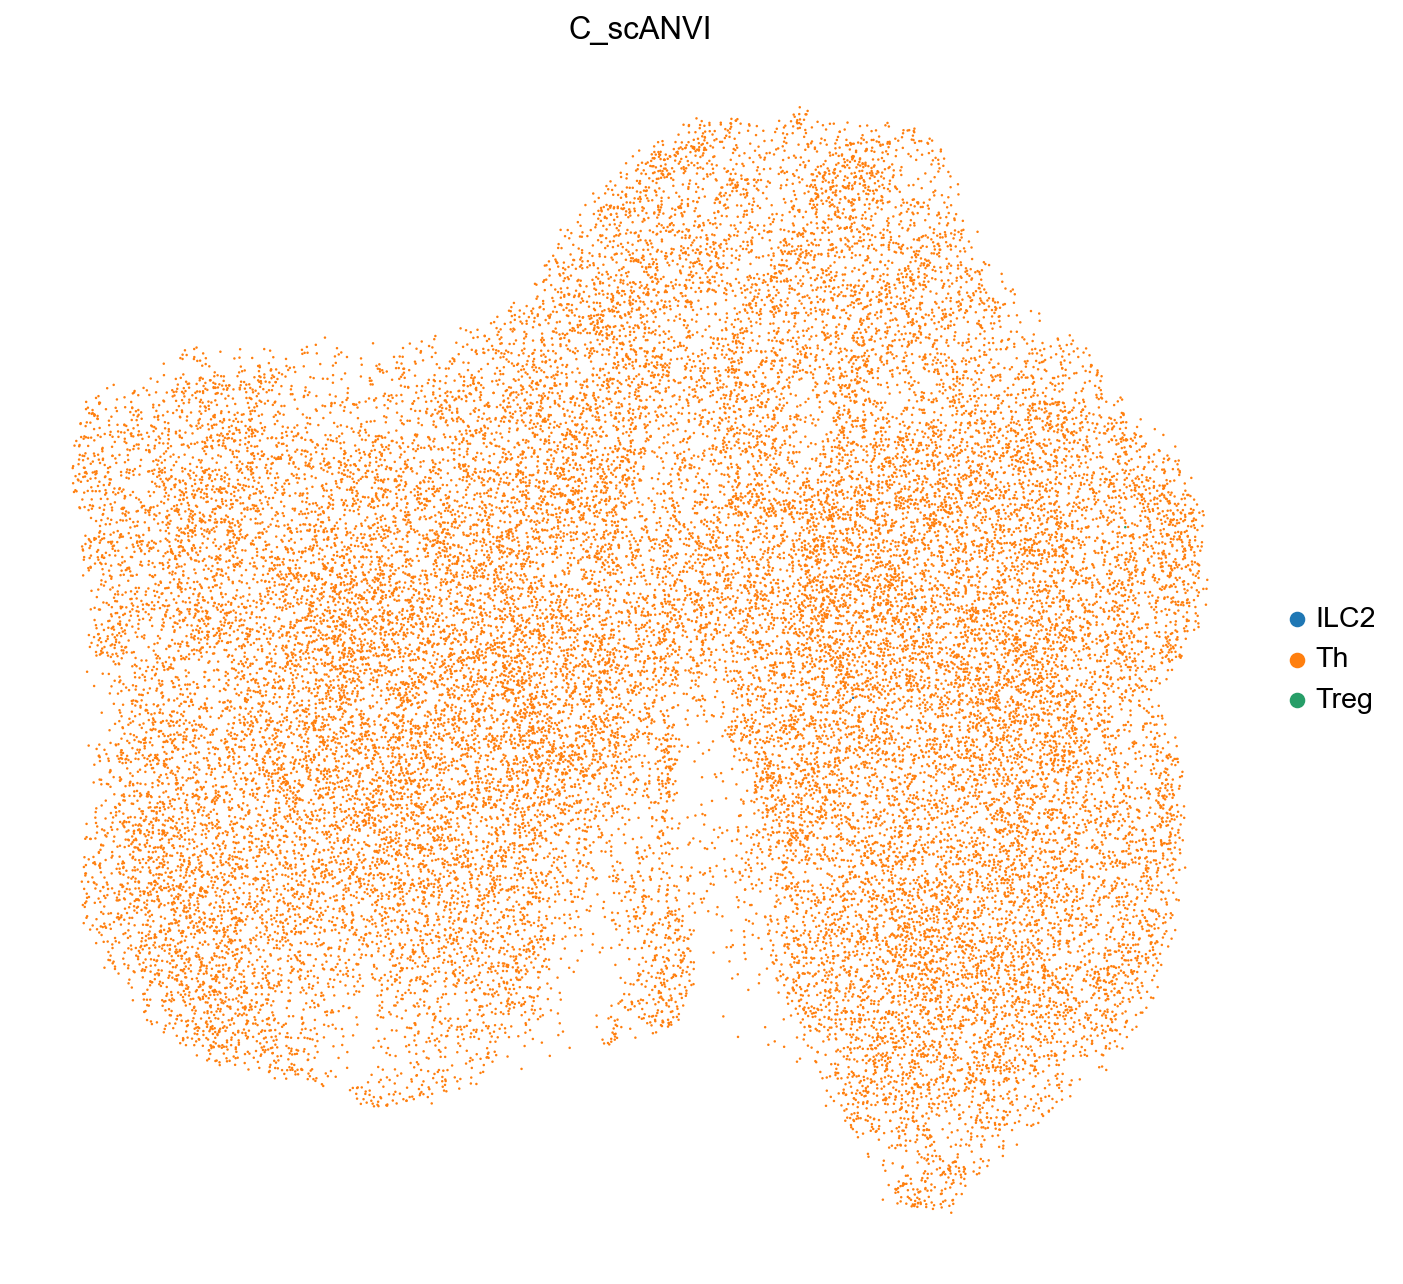

In [ ]:
sc.pl.umap(t_cells, color=["C_scANVI"], ncols=1, frameon=False,size=5)

In [ ]:
t_cell_types=t_cells.obs[t_cells.obs['batch']=='0'][['C_scANVI']]

In [ ]:
t_cell_types.C_scANVI.value_counts()

C_scANVI
Th      14401
ILC2        0
Treg        0
Name: count, dtype: int64

In [ ]:
t_cell_types.index=t_cell_types.index.str.extract("([A-Z]+-[0-9]+)-0")[0]

In [ ]:
t_cell_types

C_scANVI
0                           
AAACGCTTCGTCTCAC-1        Th
AACAAGAAGCCTCAAT-1        Th
AACACACGTAGGTAGC-1        Th
AACCACACATGAGGGT-1        Th
AAGTTCGAGGTCATCT-1        Th
...                      ...
TCCACGTAGACTACGG-20       Th
TCCTAATCAATCGCCG-20       Th
TCCTCGACACCATAAC-20       Th
TGACGCGGTAGGTCAG-20       Th
TTCTGTACATCCCACT-20       Th

[14401 rows x 1 columns]

In [ ]:
cell_types['C_scANVI']=cell_types['C_scANVI'].astype(str)

In [ ]:
cell_types.loc[t_cell_types.index,'C_scANVI']=t_cell_types['C_scANVI'].astype(str)

In [ ]:
t_cell_types=t_cells.obs[t_cells.obs['batch']=='0'][['C_scANVI']]
t_cell_types.index=t_cell_types.index.str.extract("([A-Z]+-[0-9]+)-0")[0]

In [ ]:
t_cells.obs[t_cells.obs['batch']=='0'].C_scANVI.value_counts()

C_scANVI
Macro_1     7365
Mono_mac    3107
Macro_2     2853
DC2          841
Inf_mac      803
DC1          686
moDC         448
migLC        378
MigDC        368
LC            19
Name: count, dtype: int64

In [ ]:
cell_types['C_scANVI']=cell_types['C_scANVI'].astype(str)

In [ ]:
cell_types.loc[t_cell_types.index,'C_scANVI']=t_cell_types['C_scANVI'].astype(str)

In [ ]:
cell_types['C_scANVI'].value_counts()

C_scANVI
Th                     14401
Macro_1                 7365
Tc                      5527
F2                      4773
VE2                     3302
Mono_mac                3107
Macro_2                 2853
Treg                    2815
F3                      1596
Mast_cell                976
ILC1_NK                  910
DC2                      841
Pericyte_1               804
Inf_mac                  803
DC1                      686
F1                       607
Differentiated_KC        583
VE1                      546
LE1                      507
VE3                      499
moDC                     448
Melanocyte               413
migLC                    378
MigDC                    368
Undifferentiated_KC      270
Pericyte_2               213
ILC1_3                   155
NK                       153
LE2                      122
Schwann_2                 34
LC                        19
Plasma                    16
ILC2                      13
Schwann_1                 11
Name:

In [ ]:
cell_types.to_csv(os.path.join(results_folder,"cell_types_scANVI.csv"),index_label='barcode')